In [1]:
# from gensim.summarization import keywords
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from spacy.lang.en import English
nlp = English()
nlp.max_length = 10000000
import lyricsgenius
import pandas as pd
from textblob import TextBlob
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahdiraghib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_successful = pd.read_csv('Hot100.csv')
df_successful['year'] = df_successful['WeekID'].str[:4]
month = df_successful['WeekID'].str[5:7]
df_successful['month'] = month
# df_unsuccessful = pd.read_csv('UnsuccessfulSong.csv')

# df_successful.head()

In [4]:
df_features = pd.read_excel('Hot100AudioFeatures.xlsx') 
# df_features.head()

In [5]:
df_successful = pd.merge(df_successful, df_features, on='Song', how='left')
# df_successful.head()

In [6]:
# df.shape

df_successful.columns

Index(['WeekID', 'Unnamed: 0', 'url', 'Week Position', 'Song', 'Performer_x',
       'SongID_x', 'Instance', 'Previous Week Position', 'Peak Position',
       'Weeks on Chart', 'Lyrics', 'Sentiment', 'year', 'month', 'SongID_y',
       'Performer_y', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_duration_ms',
       'spotify_track_explicit', 'spotify_track_album', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'spotify_track_popularity'],
      dtype='object')

In [7]:
df_successful = df_successful[['Song', 'Performer_x', 'Lyrics', 'Sentiment', 'year', 'danceability', 'energy', 'loudness', 'acousticness','instrumentalness', 'valence']]
# df_successful.head()

In [8]:
df_unsuccessful = pd.read_csv('UnsuccessfulSong.csv')
# df_unsuccessful.columns

In [9]:
def get_lyric_sentiment(lyrics): 
	''' 
	Function to return sentiment score of each song
	'''
	analysis = TextBlob(lyrics) 
	return analysis.sentiment.polarity

In [10]:
sentiment = df_unsuccessful.apply(lambda row: get_lyric_sentiment(row['lyrics']), axis =1)
df_unsuccessful['Sentiment'] = sentiment

In [11]:
df_unsuccessful = df_unsuccessful[['artist_name', 'track_name', 'release_date', 'lyrics', 'Sentiment', 'danceability','loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']]
df_unsuccessful.head()

,artist_name,track_name,release_date,lyrics,Sentiment,danceability,loudness,acousticness,instrumentalness,valence,energy
0,mukesh,mohabbat bhi jhoothi,1950,hold time feel break feel untrue convince spea...,-0.096875,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110
1,frankie laine,i believe,1950,believe drop rain fall grow believe darkest ni...,0.450000,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240
2,johnnie ray,cry,1950,sweetheart send letter goodbye secret feel bet...,-0.110000,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112
3,pérez prado,patricia,1950,kiss lips want stroll charm mambo chacha merin...,0.150000,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736
4,giorgos papadopoulos,apopse eida oneiro,1950,till darling till matter know till dream live ...,0.134091,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375


In [12]:
df_successful = df_successful.drop_duplicates(subset=['Song'], keep='first')
df_successful = df_successful.reset_index(drop=True)

df_unsuccessful = df_unsuccessful.drop_duplicates(subset=['track_name'], keep='first')
df_unsuccessful = df_unsuccessful.reset_index(drop=True)

In [13]:
df_successful.shape

(21741, 11)

In [14]:
print(len(df_unsuccessful[df_unsuccessful['track_name'].isin(df_successful['Song'])]))

18


In [15]:
df_unsuccessful = df_unsuccessful[~df_unsuccessful['track_name'].isin(df_successful['Song'])]

print("Number of unique unsuccessful songs: ", len(df_unsuccessful['track_name'].unique()))

Number of unique unsuccessful songs:  23671


In [16]:
df_unsuccessful = df_unsuccessful.rename(columns={'track_name': 'Song', 'artist_name': 'Performer_x', 'release_date': 'year', 'lyrics': 'Lyrics'})

In [17]:
df_successful['successful'] = 1

df_unsuccessful['successful'] = 0

In [18]:
df = pd.concat([df_successful, df_unsuccessful], ignore_index=True)

df = df.dropna()

df = df.drop_duplicates(subset=['Song'], keep='first')

df = df.reset_index(drop=True)

# df.head()
df.shape

(42149, 12)

In [19]:
#  Logistic Regression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = df[['Sentiment', 'danceability', 'energy', 'loudness', 'acousticness','instrumentalness', 'valence']]

y = df['successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[7163,    0],
       [   3, 5479]])

In [ ]:
# a new model with only Sentiment as the independent variable
X = df[['Sentiment', 'danceability', 'energy', 'acousticness','instrumentalness', 'valence']]
y = df['successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))
print("F1-score:",metrics.f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.6175563463819692
Precision: 0.6120985599260963
Recall: 0.6175563463819692
F1-score: 0.6111971509878914


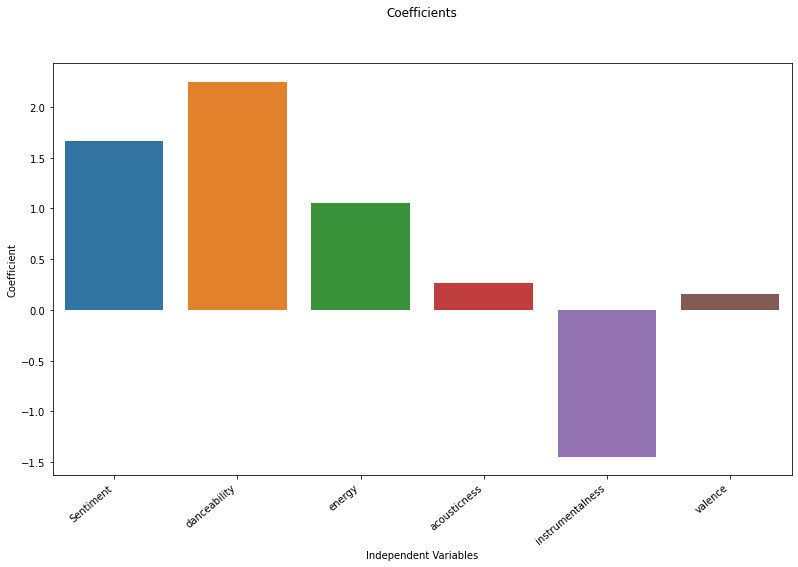

In [ ]:
plt.figure(figsize=(11,7))
ax = sns.barplot(x=X_train.columns, y=logreg.coef_[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Coefficients', y=1.1)
plt.ylabel('Coefficient')
plt.xlabel('Independent Variables')
# plt.grid()

plt.show()